In [2]:
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import keras
from keras import losses, metrics, layers, ops

In [3]:
train_df = pd.read_csv('data/train.csv')

In [4]:
train_set_df = train_df[['agent1', 'agent2', 'EnglishRules', 'LudRules']]

In [5]:
lud_preprocessor = layers.TextVectorization(
    vocabulary='ludii_tokens.dic',
    standardize='strip_punctuation'
)

eng_preprocessor = layers.TextVectorization(
    vocabulary='eng_tokens.dic'
)

max_eng = 0
max_lud = 0

eng_uniques = train_set_df['EnglishRules'].unique()

for engrul in tqdm(eng_uniques):
    eng_vector = eng_preprocessor(engrul)
    max_eng = max(max_eng, eng_vector.shape[0])

print(max_eng)


100%|██████████| 1328/1328 [00:05<00:00, 260.12it/s]

858


In [6]:
lud_uniques = train_set_df['LudRules'].unique()

EQPMNT_RE = r'\(equipment'
RULESTRIP_RE = r'[^a-zA-Z\(\)\{\}]'

for rule in lud_uniques:
    start = re.search(EQPMNT_RE, rule).span()[0]
    pure_rule = rule[start:]
    pure_rule = re.sub(RULESTRIP_RE, ' ', pure_rule)
    lud_vector = lud_preprocessor(pure_rule)
    max_lud = max(max_lud, lud_vector.shape[0])

print(max_lud)

23613


In [7]:
agent1_uniques = train_set_df['agent1'].unique()
agent2_uniques = train_set_df['agent2'].unique()

set(agent1_uniques) >= set(agent2_uniques)

code_agent = {}
agent_code = {}

for id, agent in enumerate(agent1_uniques):
    code_agent[id] = agent
    agent_code[agent] = id


eng_vector.shape=(900,)

lud_vector.shape=(23700,)

agents_to_categorical.shape=(144)

In [8]:
# 900+23700+144 = 24744
# defining input shape and input data distribution

agents_len = 144
engvector_len = 900
ludvector_len = 23700

enter = layers.Input(shape=(24744,))
agent_input_layer = layers.Input(shape=(agents_len,))
agent_input_data = ops.slice(enter, (0,), (agents_len,))

engrul_input_data = ops.slice(enter, (agents_len,), (engvector_len,))

ludrul_input_data = ops.slice(enter, (agents_len+engvector_len,), (ludvector_len,))

In [9]:
# English rules LSTM features extractor.
# 
# Train set contains 587 preextracted features.
# Let`s assume that game rule contains these features and ather that describes 
# Number of these features is unknown and needs to be discovered
# presume that total amount of fetures, that are important for game result prediction is not less then double amount 
# of preextracted features and to be 1200

FEATURES_NUM = 1200


In [10]:
# EngRule LSTM

engrul_input_layer = layers.Input(shape=(engvector_len,))
eng_emb = layers.Embedding(input_dim=3692, output_dim=512)(engrul_input_layer)
eng_x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(eng_emb)
eng_x = layers.Bidirectional(layers.LSTM(512))(eng_x)
eng_out = layers.Dense(FEATURES_NUM, activation='relu')(eng_x)

# model = keras.Model(inputs=[enter], outputs=[eng_out])

# model.summary()

In [11]:
# LudRule LSTM

ludrul_input_layer = layers.Input(shape=(ludvector_len,))
lud_emb = layers.Embedding(input_dim=1240, output_dim=512)(ludrul_input_layer)
lud_x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(lud_emb)
lud_x = layers.Bidirectional(layers.LSTM(512))(lud_x)
lud_out = layers.Dense(FEATURES_NUM, activation='relu')(lud_x)


In [12]:
assemble = layers.Concatenate(axis=1)([agent_input_layer, eng_out, lud_out])
x = layers.Dense(1200, activation='relu')(assemble)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='tanh')(x)

model = keras.Model(inputs=[agent_input_layer, engrul_input_layer, ludrul_input_layer],
                    outputs=[out])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 900)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 23700)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 900, 512)  │  1,890,304 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 23700,     │    634,880 │ input_layer_3[0]… │
│ (Embedding)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 900, 1024) │  4,198,400 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 23700,     │  4,198,400 │ embedding_1[0][0] │
│ (Bidirectional)     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 1024)      │  6,295,552 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 1024)      │  6,295,552 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 144)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1200)      │  1,230,000 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1200)      │  1,230,000 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2544)      │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1200)      │  3,054,000 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    614,912 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,773,585 (113.58 MB)

 Trainable params: 29,773,585 (113.58 MB)

 Non-trainable params: 0 (0.00 B)

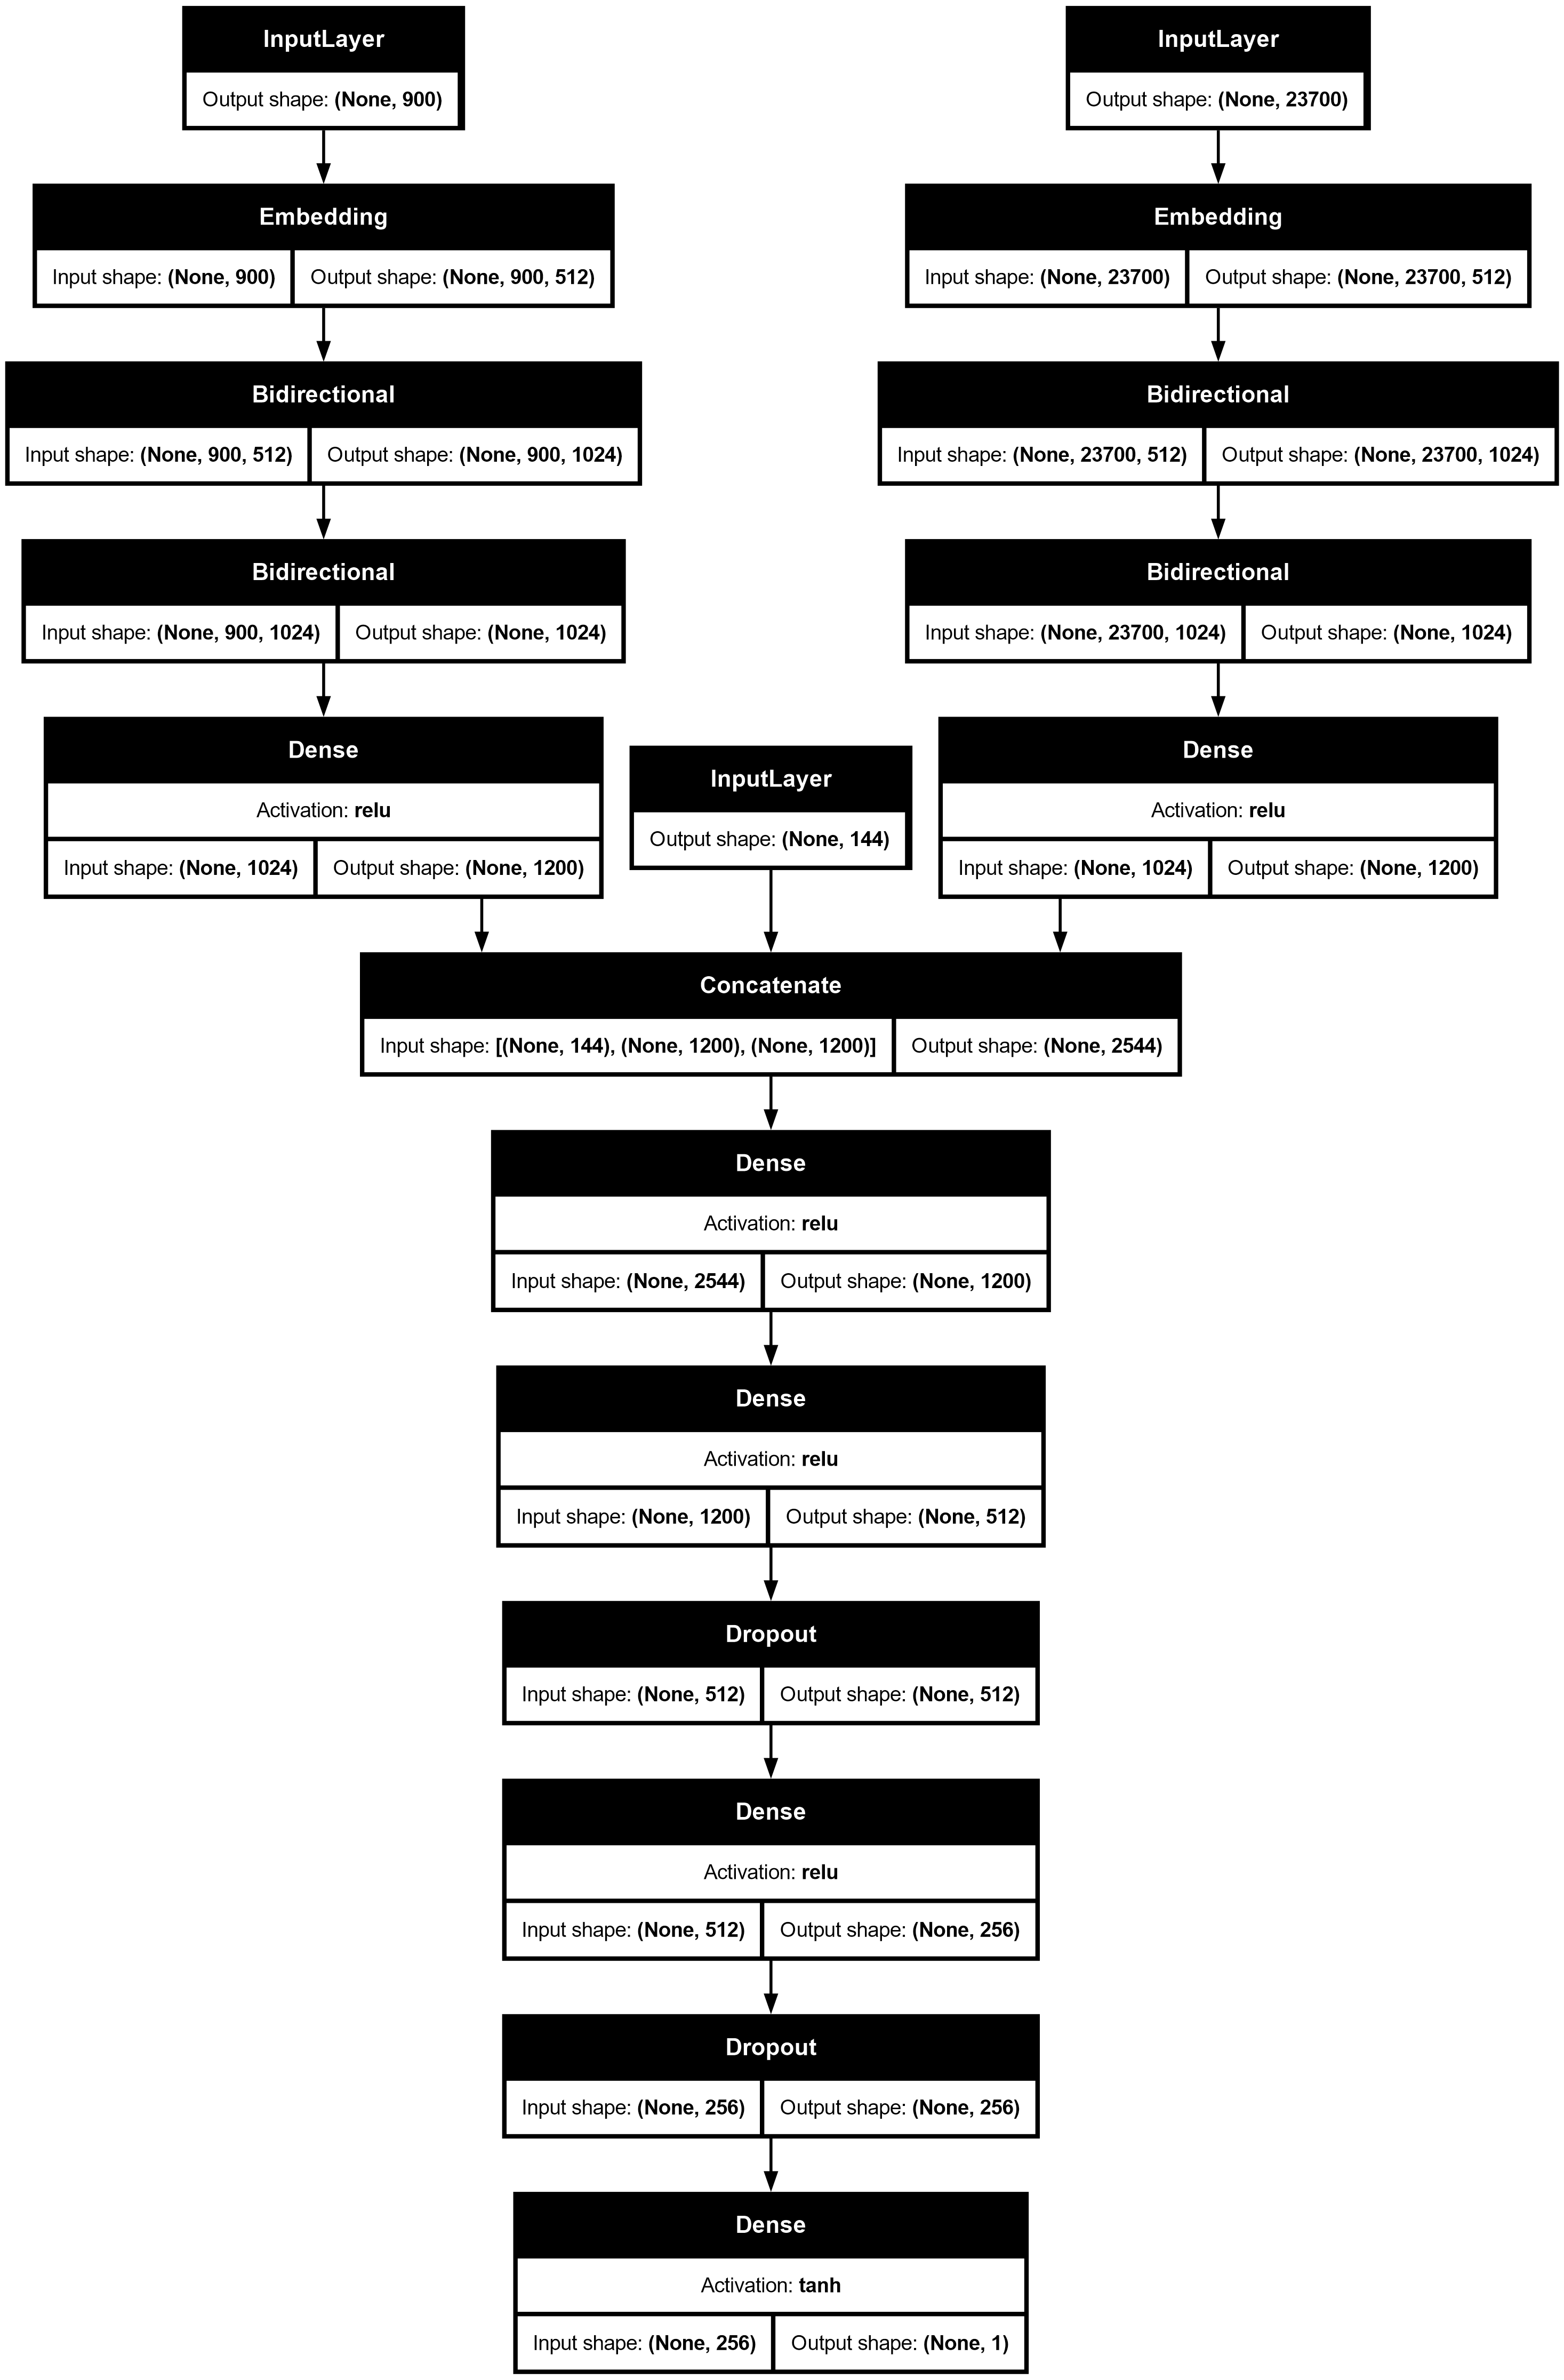

In [14]:
keras.utils.plot_model(model,
                       show_shapes=True,
                       expand_nested=True,
                       show_layer_activations=True)